In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
import random

In [4]:
def show_img(img: ndarray, title: str = ''):
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

## encoding

### ASCII Color Channel text encoding method overview

1. Encode text into a 64x64 RGB raw image
2. Give the encoded image to the model
3. Model modifies the remaining pixels to look like a face

The limited number of pixels will inevitably limit the number of characters, but we're looking for a way to encode the character in a way that best suits the model while pushing the limit.

The current method of encoding text into an image is to convert each character to its ASCII number and store it in one of the RGB color channels of the 64 pixels. So we'll be able to store 192 characters per image. It is also worth noting that increasing the number of characters will result in more occupied pixels in the raw input image, thus most likely decreasing the quality of the output avatar.

The order of filling the color channels is important:

  - The order should be consistent in order for the model to learn to generate avatars better and to make the decoding process easier.
    - The user can provide a random seed to shuffle the order of the indices, which can be stored at a fixed position in the image.
  - We don't want any of the occupied color channels to overlap unless there is no empty one left (after 64 characters) [second advantage above].
  - Given the normal distribution of left-right symmetry in training examples, the order of filling color channels should be such that it results in a symmetric input image.

![normal distribution of avatars symmetry](./assets/normal-dist-plot.png)

---

Advantages of ASCII-Color-Channel method:

  1. Straightforward
  2. Filling only one color channel per a character allows the model to modify the available color channels of the same pixel to come up with the best color to create the avatar.

Disadvantages:

  1. Limitation in character range: 0-255 (color channel intensity)


## Code representation

ASCII characters in the range of 0-255

In [ ]:
for c in range(0, 255):
    print(chr(c), end='')

# printing special characters terminated the rendering of the rest of the notebook due to a github bug, so commented them manually:
# [special characters] !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ [more special characters]

We'll just generate a random order of indexes for filling the color channels

In [8]:
idxs = list(np.arange(0, 8*8*3))

np.random.seed(42)
np.random.shuffle(idxs)

print(', '.join(str(i) for i in idxs))

45, 136, 76, 143, 113, 177, 15, 18, 16, 9, 78, 112, 66, 65, 153, 30, 145, 69, 111, 68, 171, 154, 118, 98, 67, 115, 24, 158, 60, 141, 114, 166, 19, 90, 170, 5, 133, 142, 165, 82, 109, 162, 35, 135, 42, 182, 101, 55, 75, 126, 29, 156, 56, 51, 163, 38, 31, 155, 12, 41, 159, 189, 184, 97, 26, 123, 85, 95, 2, 46, 100, 93, 128, 36, 180, 22, 183, 117, 127, 11, 119, 152, 6, 27, 104, 4, 32, 124, 138, 122, 137, 10, 62, 96, 139, 0, 172, 146, 70, 187, 64, 44, 120, 28, 40, 148, 175, 25, 23, 144, 140, 81, 108, 79, 84, 39, 125, 86, 77, 186, 161, 47, 94, 147, 190, 61, 73, 33, 43, 132, 3, 105, 53, 173, 150, 178, 49, 80, 34, 7, 110, 91, 83, 169, 174, 89, 8, 13, 59, 164, 131, 17, 72, 168, 134, 167, 176, 63, 54, 107, 50, 188, 58, 48, 88, 21, 57, 160, 185, 129, 37, 157, 181, 1, 52, 149, 130, 151, 103, 99, 116, 87, 74, 121, 191, 20, 71, 106, 14, 92, 179, 102


Encoding text in the color channels in the specified order

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


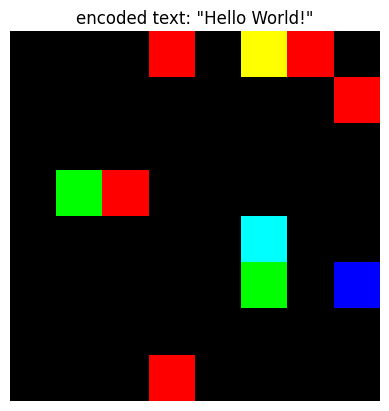

In [282]:
text = 'Hello World!'

img = np.zeros((1, 8 * 8 * 3))
for i, c in enumerate(text):
    img[0, idxs[i]] = ord(c)

show_img(img.reshape((8, 8, 3)), f'encoded text: "{text}"')

The yellow, and purplish colors in the image above are the result of overlapping color channels. We don't want this to happen for such a short text.

Illustrating the expected output, and input of the model

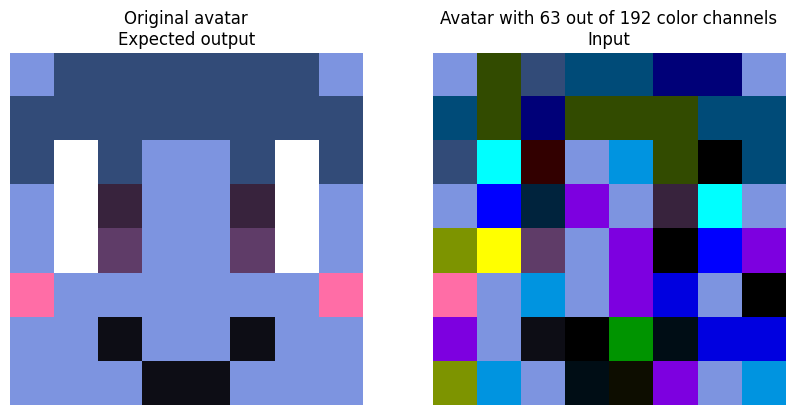

In [25]:
selected_idxs = idxs[:len(idxs) - np.random.choice(np.arange(0, len(idxs)))]

img = np.array(Image.open('../valid_faces/00001.png'))

new_img = img.copy()
new_img = new_img.reshape(8*8*3)
new_img[selected_idxs] = 0

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original avatar\nExpected output')

axs[1].imshow(new_img.reshape((8, 8, 3)))
axs[1].axis('off')
axs[1].set_title(f'Avatar with {len(selected_idxs)} out of 192 color channels\nInput')

plt.show()

Se we can generate 192 examples per each avatar to train our model, With original image being a non-encoded image and a raw black image being a fully encoded image representation.

## Ideas & Thoughts

- Calculate the estimated location of the most important pixels, such as eyes, mouth, hair, etc., and consider them when defining the order of the color channels.
- Model decides the order of encoded color channels.